In [1]:
import csv

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm, patches, cycler
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, AutoMinorLocator, ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.offsetbox import AnchoredText
from scipy.optimize import curve_fit
from scipy.special import erf

from utils import get_flare_class, get_snr
from morph import exp_gaus_single, get_flare_type, sim_data

np.set_printoptions(suppress=True)

defaultcolor = '#002060'
plt.rcParams.update({'text.color': defaultcolor, 'axes.labelcolor': defaultcolor, 
                     'xtick.color': defaultcolor, 'ytick.color': defaultcolor,
                     'axes.prop_cycle': cycler(color=['b', 'r', 'limegreen']),
                     'font.family':'serif', 'font.serif': 'Times New Roman',
                     'font.size': 22, 'lines.linewidth': 3,
                     'figure.figsize': (9.6, 5.4), 'figure.dpi': 100})

In [2]:
filtered_flares = pd.read_csv('./Runs/run3/allflares_preprocessed.csv')

In [3]:
filtered_flares.keys()

Index(['date', 'identifier', 'start_time', 'start_count', 'peak_time',
       'peak_count', 'end_time', 'end_count', 'scpeaks0-05',
       'multi_flare_region_flag', 'region_resolved_flag', 'flare_class',
       'background', 'amplitude', 'mu', 'sigma', 'tau', 'redchisq', 'rsquared',
       'snr', 'fluence', 'sigma-by-tau', 'flare_type', 'duration'],
      dtype='object')

In [4]:
columns = ['identifier', 'peak_count', 'flare_class', 'background_slope', 'background_intercept', 'amplitude', 'mu', 'sigma', 'tau', 'sigma-by-tau', 'snr', 'flare_type', 'discrepancy_flag']     # discrepancy_flag = 1 indicates misclassification after adding noise
# TODO: Maybe add r-squared and redchisq

In [5]:
filtered_flares[['peak_count', 'amplitude', 'sigma', 'tau', 'background']].median()

peak_count     49.23
amplitude     127.69
sigma         135.16
tau           287.74
background    158.70
dtype: float64

In [6]:
filtered_flares[['peak_count', 'flare_class', 'amplitude', 'sigma', 'tau', 'background', 'flare_type']][:10]

,peak_count,flare_class,amplitude,sigma,tau,background,flare_type
0,101.03,B1,311.52,61.21,329.99,486.17,B
1,42.79,A4,43.39,147.99,25.00,414.51,A
2,507.60,B5,2114.62,175.50,1230.74,434.21,B
3,103.02,B1,513.42,364.05,3518.37,326.08,B
4,20.66,A2,20.89,357.32,54.72,326.08,F
5,797.72,B7,2834.86,38.63,252.30,321.35,B
6,137.88,B1,414.99,481.85,2512.16,321.35,B
7,96.99,A9,1295.65,99.06,3043.35,391.40,B
8,444.71,B4,469.62,3362.39,1141.86,0.00,A
9,28.07,A2,28.59,199.60,39.31,446.31,A


In [7]:
def plot_flare(time, counts, error, inputparams, plot=False):

    xt = time
    yt = counts
    yerr = error
    popt, pcov = curve_fit(exp_gaus_single, xt, yt, p0=inputparams)

    if plot == True:
        fig, axs = plt.subplots(2, figsize=(9.6, 9.6), gridspec_kw={'height_ratios': [3, 1]})
        
        plt.xlabel('Time (s)')
        plt.subplots_adjust(hspace=.0)
        linestyle = {"elinewidth":1, "capsize":0, "ecolor":"grey"}
        plt.setp(axs[0].get_xticklabels(), visible=False)

        axs[0].errorbar(xt, yt, yerr=yerr, fmt='D', ms=3, c='blue', **linestyle)

        for ax in axs:
            ax.tick_params(which='major', width=1)
            ax.tick_params(which='major', length=4)
            ax.margins(x=0)
        axs[0].set_ylabel('Flux (nW/m$^2$)')
        axs[1].set_ylabel('Residual ((o-f)/$\\sigma$)')
        axs[1].set_ylim(bottom=-4,top=4)

        yfit = exp_gaus_single(xt, *popt)
        axs[0].plot(xt, yfit, c='r', zorder=10, lw=3)
        axs[0].tick_params(axis='x', direction='in')
        axs[1].errorbar(xt, (yt-yfit)/np.std(yt-yfit), yerr=yerr/np.std(yt-yfit), fmt='D', ms=3, c='blue', **linestyle)
        axs[1].axhline(np.mean((yt-yfit)/np.std(yt-yfit)), linestyle='--', lw=1, c='navy')
        
        at = AnchoredText(f'Input σ/τ = {inputparams[2]/inputparams[3]:.2f}\nFit σ/τ = {popt[2]/popt[3]:.2f}', \
                prop=dict(size=18, color='black'), frameon=False, loc='upper left')
        at.patch.set_boxstyle('round,pad=0.,rounding_size=0.2')
        axs[0].add_artist(at)

        at = AnchoredText(f'A = {inputparams[0]:.2f}| {popt[0]:.2f}\n\
                            $\\mu$ = {inputparams[1]:.2f}| {popt[1]:.2f}\n\
                            σ = {inputparams[2]:.2f}| {popt[2]:.2f}\n\
                            τ = {inputparams[3]:.2f}| {popt[3]:.2f}\n\
                            m = {inputparams[4]:.2f}| {popt[4]:.2f}\n\
                            c = {inputparams[5]:.2f}| {popt[5]:.2f}\n', \
                prop=dict(size=18, color='black'), frameon=False, loc='upper right')
        at.patch.set_boxstyle('round,pad=0.,rounding_size=0.2')
        axs[0].add_artist(at)

        return popt, plt.gcf()

    else:
        return popt, pcov

/var/folders/5w/bxqs6l5j65vfrl397w9mj1kc0000gn/T/ipykernel_10670/1074871056.py:29: RuntimeWarning: invalid value encountered in divide
  axs[1].errorbar(xt, (yt-yfit)/np.std(yt-yfit), yerr=yerr/np.std(yt-yfit), fmt='D', ms=3, c='blue', **linestyle)
/var/folders/5w/bxqs6l5j65vfrl397w9mj1kc0000gn/T/ipykernel_10670/1074871056.py:29: RuntimeWarning: divide by zero encountered in divide
  axs[1].errorbar(xt, (yt-yfit)/np.std(yt-yfit), yerr=yerr/np.std(yt-yfit), fmt='D', ms=3, c='blue', **linestyle)
/var/folders/5w/bxqs6l5j65vfrl397w9mj1kc0000gn/T/ipykernel_10670/1074871056.py:30: RuntimeWarning: invalid value encountered in divide
  axs[1].axhline(np.mean((yt-yfit)/np.std(yt-yfit)), linestyle='--', lw=1, c='navy')


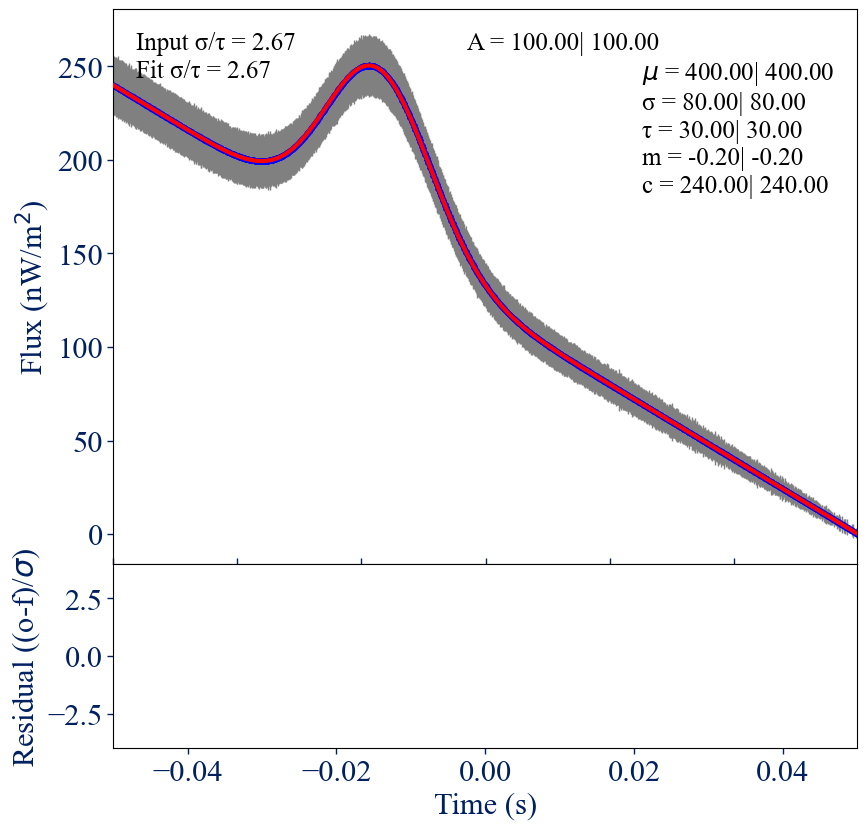

In [8]:
n = 1200

A = 100
mu = 400
sigma = 80
tau = 30
m = -0.2
c = np.abs(min(n*m, 0))

xdata = np.arange(n)
inputparams = np.array([A, mu, sigma, tau, m, c])

ydata, yerr = sim_data(xdata, inputparams, noisefree=True)

popt, fig = plot_flare(xdata, ydata, yerr, inputparams, plot=True)

In [9]:
# Modelling the type A-B curve (see full simulation methods used below)
bins_sigmabytau = np.logspace(-3, 2, 101)

yB = 10**(np.random.normal(np.log10(np.sqrt(10)/10), np.log10(10)/2.35, 10000))
yA = 10**(np.random.normal(np.log10(4), np.log10(2)/2.35, 10000))

countsB, _ = np.histogram(yB, bins=bins_sigmabytau)
countsA, _ = np.histogram(yA, bins=bins_sigmabytau)

In [10]:
runs = 20000
count_mis = 0
count_runs = runs
sigmabytau = np.random.choice(bins_sigmabytau[:-1], p=(countsA+countsB)/np.sum(countsA+countsB), size=runs)

fit_sigmabytau = []

flare_sim_list = []
flare_fit_list = []

for i in range(runs):
    discrepancy_flag = 0

    n = np.random.randint(800, 2000)
    # n = np.int32(1000 * 10 ** (np.random.normal(0, 0.42)))

    A = 50 * 10 ** (np.random.uniform(1, 2))
    mu = 0.4 * n + np.random.uniform(-100, 100) #np.random.uniform(300,500)
    tau = 350 * 10 ** (np.random.normal(0, 0.5))
    sigma = sigmabytau[i] * tau         
    while sigma > 500:              # There are some flares with sigma ~800 which are just long duration. TODO: Improve this prior
        tau = 350 * 10 ** (np.random.normal(0, 0.5))
        sigma = sigmabytau[i] * tau

    m = np.random.uniform(-0.15, 0.15)
    c = np.abs(min(n*m, 0)) + 100 * 10 ** np.random.normal(0, 0.5)

    xdata = np.arange(n)
    inputparams = np.array([A, mu, sigma, tau, m, c])

    ydata, yerr = sim_data(xdata, inputparams, noisefree=True)

    try:
        # popt, pcov = plot_flare(xdata, ydata, yerr, inputparams)
        popt, fig = plot_flare(xdata, ydata, yerr, inputparams, plot=False)
    except RuntimeError:
        count_runs -= 1     # This run was not accounted for
        continue

    fit_sigmabytau.append(popt[2]/popt[3])
    # Override input if sigma/tau of data and fit don't match
    sim_flare_type = get_flare_type(inputparams[2], inputparams[3])
    fit_flare_type = get_flare_type(popt[2], popt[3])
    if sim_flare_type != fit_flare_type:
        discrepancy_flag = 1      # Misclassification due to fitting
        count_mis += 1

    # plt.savefig(f'Runs/sim/plots/{i}.png')
    # plt.close()

    # Data packaging
    sim_background = m * xdata + c
    sim_signal = exp_gaus_single(xdata, *inputparams) - sim_background
    sim_peak_count = np.max(sim_signal)

    fit_background = popt[4] * xdata + popt[5]
    fit_signal = exp_gaus_single(xdata, *popt) - fit_background
    fit_peak_count = np.max(fit_signal)

    flare_sim_list.append([i, sim_peak_count, get_flare_class(sim_peak_count), m, c, A, mu, sigma, tau, sigma/tau, np.sum(get_snr(sim_signal, sim_background)), sim_flare_type, discrepancy_flag])
    flare_fit_list.append([i, fit_peak_count, get_flare_class(fit_peak_count), popt[4], popt[5], popt[0], popt[1], popt[2], popt[3], fit_sigmabytau[-1], np.sum(get_snr(fit_signal, fit_background)), fit_flare_type, discrepancy_flag])

    # Save light curve
    filename = f'Runs/sim/flares/{i}.csv'
    with open(filename, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["Time", "Counts", "Error"])
        writer.writerows(np.vstack([xdata, ydata, yerr]).T)

print(count_mis / count_runs)

/Users/penguin/miniconda3/envs/xsm/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/penguin/Documents/Grad School/Research/XSM/XSM-Analysis/multiflarefit2/utils.py:282: RuntimeWarning: divide by zero encountered in log10
  flare_class_val = np.log10(flux) - 1


0.0


/var/folders/5w/bxqs6l5j65vfrl397w9mj1kc0000gn/T/ipykernel_10670/1074871056.py:29: RuntimeWarning: invalid value encountered in divide
  axs[1].errorbar(xt, (yt-yfit)/np.std(yt-yfit), yerr=yerr/np.std(yt-yfit), fmt='D', ms=3, c='blue', **linestyle)
/var/folders/5w/bxqs6l5j65vfrl397w9mj1kc0000gn/T/ipykernel_10670/1074871056.py:29: RuntimeWarning: divide by zero encountered in divide
  axs[1].errorbar(xt, (yt-yfit)/np.std(yt-yfit), yerr=yerr/np.std(yt-yfit), fmt='D', ms=3, c='blue', **linestyle)
/var/folders/5w/bxqs6l5j65vfrl397w9mj1kc0000gn/T/ipykernel_10670/1074871056.py:30: RuntimeWarning: invalid value encountered in divide
  axs[1].axhline(np.mean((yt-yfit)/np.std(yt-yfit)), linestyle='--', lw=1, c='navy')


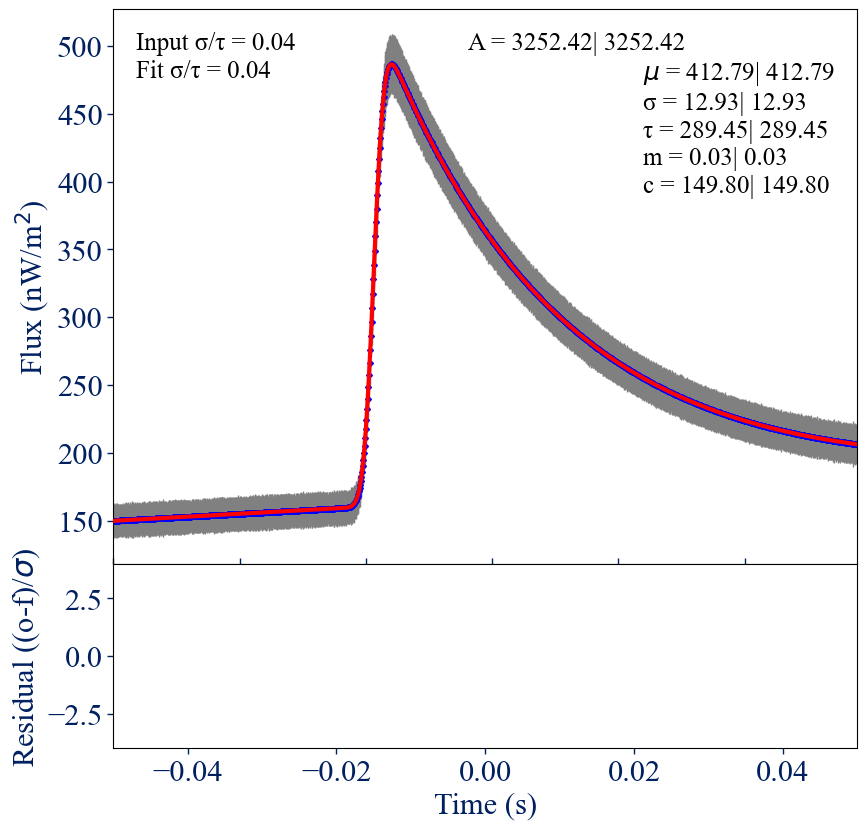

In [11]:
popt, fig = plot_flare(xdata, ydata, yerr, inputparams, plot=True)

In [12]:
pd.DataFrame(flare_fit_list, columns=columns).to_csv('Runs/sim/fitted_flares.csv')
pd.DataFrame(flare_sim_list, columns=columns).to_csv('Runs/sim/simulated_flares.csv')

In [13]:
pd.DataFrame(flare_sim_list, columns=columns)

,identifier,peak_count,flare_class,background_slope,background_intercept,amplitude,mu,sigma,tau,sigma-by-tau,snr,flare_type,discrepancy_flag
0,0,1451.138034,C1,-0.096669,1476.325447,1465.143904,797.242264,221.895101,31.343516,7.079458,12190.876623,A,0
1,1,613.205306,B6,0.059252,666.473751,1089.907748,610.706582,53.946988,120.772261,0.446684,3474.604750,B,0
2,2,916.896276,B9,-0.126848,267.911238,934.060123,568.722899,401.973888,80.204335,5.011872,28314.287699,A,0
3,3,584.834486,B5,0.071710,61.022220,590.475307,519.089490,331.040789,46.760754,7.079458,17670.857311,A,0
4,4,563.885328,B5,0.067712,334.278694,1650.206980,247.896650,47.894096,240.039093,0.199526,5448.700584,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,1893.383755,C1,-0.148098,191.352181,1994.883750,579.118904,308.231508,109.364666,2.818383,37349.114891,A,0
19996,19996,3385.483954,C3,-0.134915,194.446444,3505.789998,339.593700,386.976256,109.064728,3.548134,49719.264672,A,0
19997,19997,2930.545463,C2,0.066706,166.960928,4914.049913,693.959378,80.803703,161.224583,0.501187,22223.821083,B,0
19998,19998,1107.944059,C1,0.049289,104.964970,2570.961356,692.152899,31.952159,113.370539,0.281838,7022.169649,B,0


In [480]:
columns

['identifier',
 'peak_count',
 'flare_class',
 'background_slope',
 'background_intercept',
 'amplitude',
 'mu',
 'sigma',
 'tau',
 'sigma-by-tau',
 'snr',
 'flare_type',
 'discrepancy_flag']

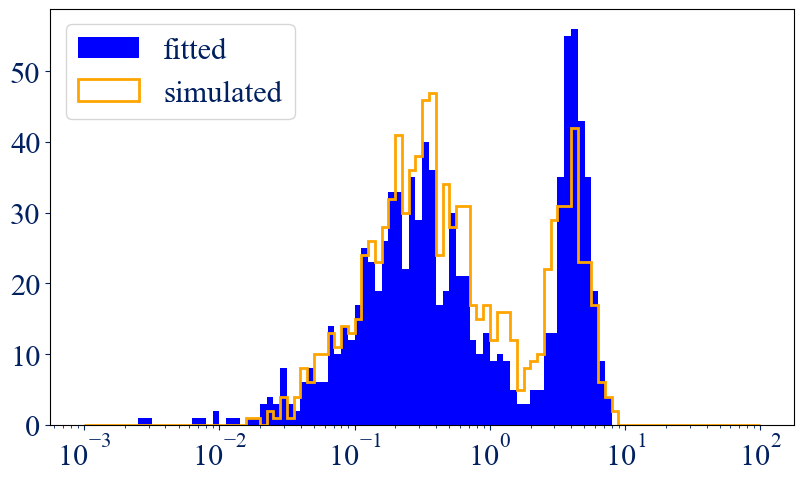

In [378]:
plt.hist(fit_sigmabytau, bins=bins_sigmabytau, label='fitted')
plt.hist(sigmabytau, bins=bins_sigmabytau, histtype='step', lw=2, edgecolor='orange', label='simulated')
plt.xscale('log')
plt.legend()
plt.show()

In [87]:
(inputparams - popt) / inputparams

array([ 0.03307833, -0.03559546, -0.0226029 ,  0.5535872 , -0.00045928,
        0.00001665])

### Amplitude, Sigma and Tau Priors

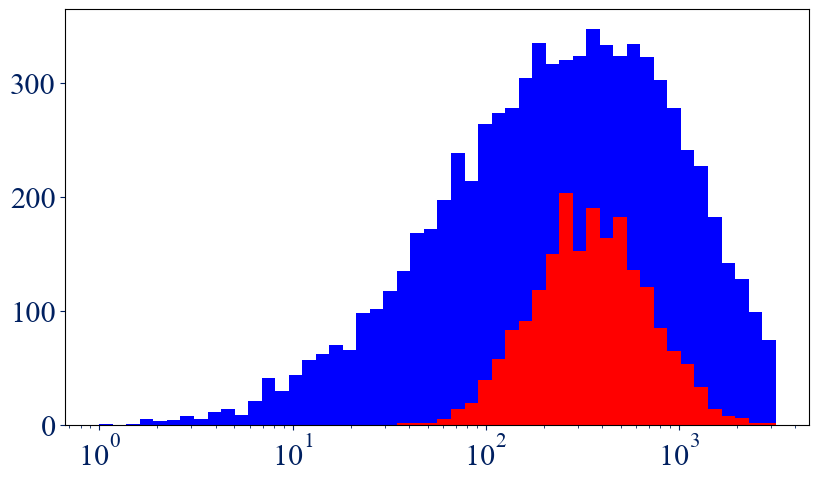

In [ ]:
plt.hist(filtered_flares['tau'], bins=np.logspace(0,3.5,51))
plt.hist(350 * 10 ** (np.random.normal(0, 0.3, 2000)), bins=np.logspace(0,3.5,51))        # for tau
plt.xscale('log')

In [454]:
filtered_flares[filtered_flares['sigma'] > 300]

,date,identifier,start_time,start_count,peak_time,peak_count,end_time,end_count,scpeaks0-05,multi_flare_region_flag,...,mu,sigma,tau,redchisq,rsquared,snr,fluence,sigma-by-tau,flare_type,duration
3,20221104,20221104ao,72505.0,10.25,73475.0,103.02,75295.0,70.03,6,True,...,73015.00,364.05,3518.37,189.323,0.822,292.76,7879.08,0.103471,B,2790.0
4,20221104,20221104an,71875.0,0.00,74915.0,20.66,75295.0,11.98,6,True,...,74863.92,357.32,54.72,189.323,0.248,19.31,532.73,6.529971,F,3420.0
6,20221104,20221104am,64975.0,35.54,66105.0,137.88,69445.0,40.37,2,True,...,65385.00,481.85,2512.16,316.959,0.810,881.03,23972.47,0.191807,B,4470.0
8,20221104,20221104aj,58735.0,432.06,59275.0,444.71,61255.0,403.97,3,False,...,58615.00,3362.39,1141.86,106.261,0.708,2342.16,48569.32,2.944660,A,2520.0
10,20221104,20221104ah,51175.0,97.04,52175.0,157.67,54295.0,71.75,6,False,...,51345.00,820.44,1898.60,143.020,0.868,738.77,20059.99,0.432129,B,3120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8008,20191002,20191002ac,43235.0,0.30,44145.0,2.96,45255.0,0.29,32,False,...,43917.53,391.14,292.94,0.665,0.598,106.08,326.33,1.335222,B,2020.0
8021,20191001,20191001ag,24805.0,0.49,25475.0,4.90,26155.0,0.49,34,True,...,25404.66,305.90,74.07,0.744,0.738,133.96,383.07,4.129877,A,1350.0
8023,20191001,20191001ae,10615.0,12.93,12325.0,56.89,15185.0,5.67,33,False,...,11709.20,879.05,874.03,7.538,0.982,2115.15,14975.11,1.005744,B,4570.0
8026,20190930,20190930am,78125.0,0.93,78975.0,9.29,79845.0,0.92,22,True,...,78890.25,390.10,91.85,1.841,0.848,206.05,898.94,4.247142,A,1720.0


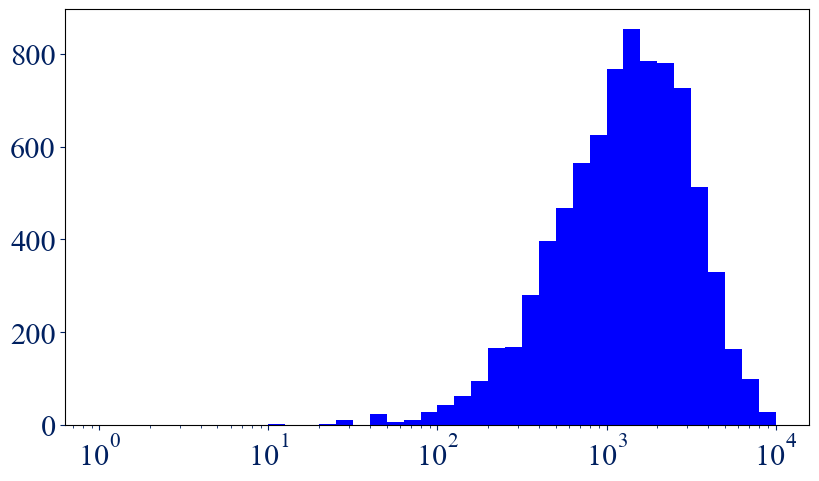

In [462]:
filtered_flares['duration'].median(), filtered_flares['duration'].mean()
plt.hist(filtered_flares['duration'], bins=np.logspace(0,4,41))
plt.xscale('log')
plt.show()

### Modelling the type A-B curve

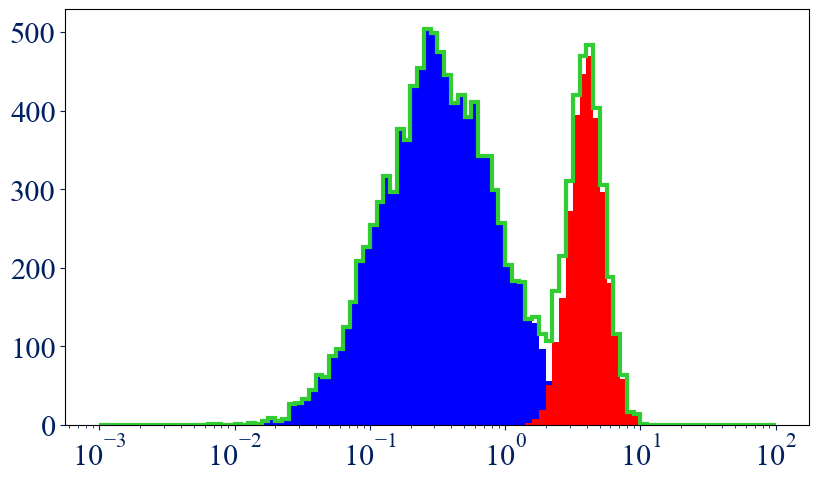

In [ ]:
# Modelling the type A-B curve
bins_sigmabytau = np.logspace(-3, 2, 101)

yB = 10**(np.random.normal(np.log10(np.sqrt(10)/10), np.log10(10)/2.35, 10000))
yA = 10**(np.random.normal(np.log10(4), np.log10(2)/2.35, 3000))

countsB, _, _ = plt.hist(yB, bins=bins_sigmabytau)
countsA, _, _ = plt.hist(yA, bins=bins_sigmabytau)
# plt.close()
plt.stairs(countsA+countsB, bins_sigmabytau, lw=3)
plt.xscale('log')
plt.show()

In [ ]:
np.random.choice(bins_sigmabytau[:-1], p=(countsA+countsB)/np.sum(countsA+countsB))   # Sample from above type A-B curve model

0.31622776601683794

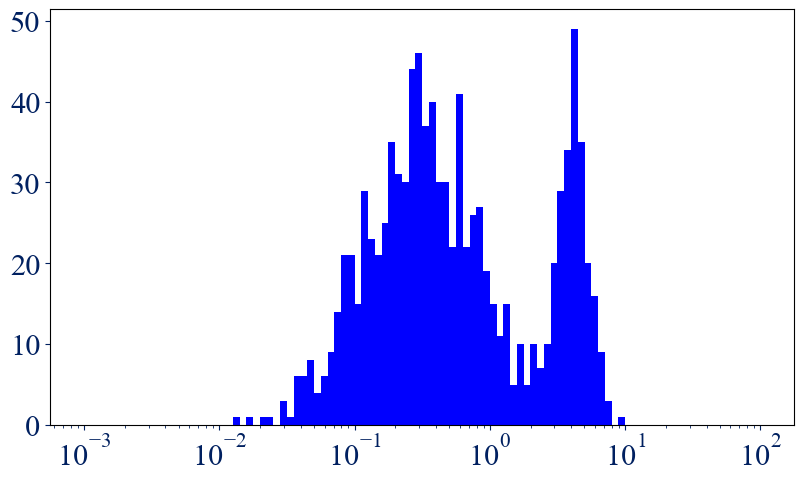

In [ ]:
# Random sampling from type A-B curve with appropriate weighting
plt.hist(np.random.choice(bins_sigmabytau[:-1], p=(countsA+countsB)/np.sum(countsA+countsB), size=1000), bins=bins_sigmabytau)
plt.xscale('log')
plt.show()

In [ ]:
# Calculating area under curve in window
cond1 = bins_sigmabytau > 1
cond2 = bins_sigmabytau < 3
window = cond1 & cond2

np.argwhere(window)

array([[61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69]])

In [ ]:
# Bin edge values for window part of the type A-B curve
bins_sigmabytau[window == True]

array([1.12201845, 1.25892541, 1.41253754, 1.58489319, 1.77827941,
       1.99526231, 2.23872114, 2.51188643, 2.81838293])

In [ ]:
# Area under window part of the type A-B curve
np.sum(((countsA+countsB)/np.sum(countsA+countsB))[window[:-1]])

0.11961538461538462